In [67]:
pip install tabgan==1.3.3

Note: you may need to restart the kernel to use updated packages.


In [68]:
!pip install lightgbm

In [69]:
pip install --upgrade pandas "dask[complete]"

Note: you may need to restart the kernel to use updated packages.


In [70]:
## librerias requeridas
import numpy as np 
import pandas as pd
import matplotlib.pyplot as plt
import calendar
import re
from sklearn.metrics import confusion_matrix 
from sklearn.model_selection import train_test_split 
from sklearn.tree import DecisionTreeClassifier 
from sklearn.metrics import accuracy_score 
from sklearn.metrics import classification_report 
from sklearn.metrics import confusion_matrix
from sklearn.metrics import precision_score, recall_score
#from scikitplot.metrics import plot_roc
from sklearn.metrics import roc_auc_score
#from scikitplot.metrics import plot_lift_curve
#from scikitplot.helpers import binary_ks_curve 
#from scikitplot.metrics import plot_ks_statistic
#from scikitplot.helpers import cumulative_gain_curve
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import RandomizedSearchCV
from lightgbm import LGBMClassifier
from datetime import datetime, timedelta

import pyarrow as pa
import pyarrow.parquet as pq

In [71]:
pd.set_option('display.max_columns', 500)
pd.set_option('display.memory_usage', True)

## Cargo el modelo y los datos a los que lo voy a aplicar 

In [72]:
import os
os.getcwd()

'/home/ec2-user/SageMaker/viamericas-dev/Analytics/5.Fraud'

In [73]:
import os
import joblib
# load model
#modelo = joblib.load("Analytics/5.Fraud/ModeloV1Todos.pkl") 
modelo = joblib.load("ModeloFinal_sin_rtc.pkl") 
variables = open('./ModeloFinal_sin_rtc.txt','r')
##ModeloV1T1

In [74]:
modelo

LGBMClassifier(colsample_bytree=0.84, importance_type='gini',
               learning_rate=0.07, max_depth=20, min_child_weight=0.0026,
               n_estimators=520, num_leaves=30, objective='binary',
               scale_pos_weight=0.003, subsample=1)

# Veo si puedo sacar los nombres directo del modelo q cargue


In [75]:
#variables = open('./ModeloFinal2.txt','r')
#var_input = variables.read()

In [76]:
var_input = ['01_branch_working_days', 'branch_minutes_since_last_transaction',
    'branch_trans_3m', 'branch_has_fraud', 
    'branch_trans_40min', 'branch_trans_10min', 'cash_pick_up_40min', 
    'location_nro_fraud', 'sender_trans_3m', 
    'sender_nro_fraud','01_isMexico', 
    '01_sender_branch_state', '01_var_range_hist',
    '01_branch_fraud', '01_location_fraud', '01_sender_fraud', 
    '01_isCashPick', '01_isBankDep', 
    'sender_days_to_last_transaction_more7m', 
    '01_sender_sending_days',
    '01_branch_working_days', '01_net_amount_receiver', 
    '01_sender_minutes_since_last_transaction_2days', 
    '01_sender_days_to_last_transaction_365', 
    '01_sender_days_to_last_transaction_7m', '01_hour_receiver']

In [77]:
s3_url = f"viamericas-datalake-dev-us-east-1-283731589572-raw/FraudModel/Data4Model/TargetTodos"
dfTrain = pd.read_parquet(f"s3://{s3_url}/Train/Train.parquet")
tgTrain = dfTrain['target']

dfVal = pd.read_parquet(f"s3://{s3_url}/Validation/Validation.parquet")
tgVal = dfVal['target']

#Uni test y Val
#X = pd.concat([dfTrain[var_input], dfVal[var_input]], ignore_index=True) 
X = pd.concat([dfTrain, dfVal], ignore_index=True) 
Y = pd.DataFrame(pd.concat([dfTrain['target'], dfVal['target']], ignore_index=True)) 

dias_target = ['day_name_receiver_0', 'day_name_receiver_1',
       'day_name_receiver_2', 'day_name_receiver_3',
       'day_name_receiver_4', 'day_name_receiver_5',
       'day_name_receiver_6','target']

testeo =  pd.concat([X, Y], axis=1)
Y_target = pd.DataFrame(pd.concat([dfTrain[dias_target], dfVal[dias_target]], ignore_index=True)) 

In [78]:
testeo[var_input]

,01_branch_working_days,branch_minutes_since_last_transaction,branch_trans_3m,branch_has_fraud,branch_trans_40min,branch_trans_10min,cash_pick_up_40min,location_nro_fraud,sender_trans_3m,sender_nro_fraud,01_isMexico,01_sender_branch_state,01_var_range_hist,01_branch_fraud,01_location_fraud,01_sender_fraud,01_isCashPick,01_isBankDep,sender_days_to_last_transaction_more7m,01_sender_sending_days,01_branch_working_days,01_net_amount_receiver,01_sender_minutes_since_last_transaction_2days,01_sender_days_to_last_transaction_365,01_sender_days_to_last_transaction_7m,01_hour_receiver
0,0.05282575884621834583,131.00000000000000000000,"2,659.00000000000000000000",0,1,1,1,0,2.00000000000000000000,0,True,True,1.00000000000000000000,False,False,False,True,False,0,0.63571428571428567622,0.05282575884621834583,0.21660649819494584567,0.00000000000000000000,0.17260273972602740988,0.29999999999999998890,0.58333333333333337034
1,0.11973838671809491907,109.00000000000000000000,"1,115.00000000000000000000",0,1,1,1,0,17.00000000000000000000,0,False,True,0.73118300535713409705,False,False,False,True,False,0,0.18392857142857144126,0.11973838671809491907,0.02166064981949458387,0.00000000000000000000,0.01643835616438356004,0.02857142857142857054,0.66666666666666662966
2,0.33724635250712731160,933.00000000000000000000,877.00000000000000000000,0,1,1,1,0,5.00000000000000000000,0,False,True,0.39062500000000000000,False,False,False,True,False,0,0.12321428571428572063,0.33724635250712731160,0.00902527075812274357,0.00000000000000000000,0.03013698630136986412,0.05238095238095238221,0.54166666666666662966
3,0.28794231091732347405,5.00000000000000000000,"4,494.00000000000000000000",0,2,2,2,0,12.00000000000000000000,0,False,True,2.43243243243243245644,False,False,False,True,False,0,0.73392857142857137465,0.28794231091732347405,0.16245487364620939119,0.00000000000000000000,0.02191780821917808236,0.03809523809523809867,0.37500000000000000000
4,0.23478115042763708642,56.00000000000000000000,751.00000000000000000000,0,1,1,1,0,2.00000000000000000000,0,True,True,1.00000000000000000000,False,False,False,True,False,0,0.83750000000000002220,0.23478115042763708642,0.72202166064981954108,0.00000000000000000000,0.16164383561643835829,0.28095238095238095344,0.50000000000000000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
16724863,0.03907429146402817410,3.00000000000000000000,942.00000000000000000000,0,5,2,5,0,1.00000000000000000000,0,True,False,1.00000000000000000000,False,False,False,True,False,0,NaN,0.03907429146402817410,0.03610108303249097428,0.00000000000000000000,NaN,NaN,0.54166666666666662966
16724864,0.23997987590139191472,60.00000000000000000000,"2,028.00000000000000000000",0,1,1,1,0,8.00000000000000000000,0,False,True,1.01587301587301581662,False,False,False,True,False,0,0.98750000000000004441,0.23997987590139191472,0.14440433212996389711,0.00000000000000000000,0.01917808219178082293,0.03333333333333333287,0.50000000000000000000
16724865,0.50025155123260101053,0.00000000000000000000,"10,118.00000000000000000000",0,9,3,8,0,8.00000000000000000000,0,False,True,1.48411689961880566280,False,False,False,True,False,0,0.21249999999999999445,0.50025155123260101053,0.10541516245487364545,0.00000000000000000000,0.01917808219178082293,0.03333333333333333287,0.75000000000000000000
16724866,0.13231594834814691675,126.00000000000000000000,"3,154.00000000000000000000",0,1,1,1,0,3.00000000000000000000,0,True,True,1.01408479269994167282,False,False,False,True,False,0,0.61785714285714288252,0.13231594834814691675,0.04332129963898916775,0.00000000000000000000,0.03561643835616438297,0.06190476190476190688,0.54166666666666662966


In [79]:
# Prediciendo la variable objetivo para el conjunto de datos de prueba 'X_TESTEO' utilizando el clasificador LightGBM
testeo_data_pred_rf = modelo.predict(testeo[var_input])

# Prediciendo las probabilidades de clase para cada observación en 'X_TESTEO' utilizando el clasificador LightGBM
probab_rf = modelo.predict_proba(testeo[var_input])

# Eliminando la primera columna (se asume que son las probabilidades de la clase negativa) de las probabilidades predichas
# Se asume que la segunda columna contiene las probabilidades para la clase positiva
score_rf = np.delete(probab_rf, np.s_[0], axis=1)

# Creando una copia del DataFrame 'Y_c' para preservar los datos originales
Y_c = Y_target.copy()

# Agregando una nueva columna 'preds_rf' al DataFrame copiado con las predicciones del clasificador LightGBM
Y_c['preds_rf'] = testeo_data_pred_rf

# Agregando una nueva columna 'score_rf' al DataFrame copiado con las probabilidades de la clase positiva
Y_c['score_rf'] = score_rf

#Calculo el primer percentil para sacar el punto de corte
percentiles = pd.qcut(Y_c['score_rf'], q=1000, duplicates='drop')
percentile_label = {p: l for l, p in enumerate(sorted(percentiles.unique(), reverse=True), start=1)}
percentiles = percentiles.map(percentile_label)
Y_c['FRAUD_DECILE'] = np.nan
Y_c['FRAUD_DECILE'] = percentiles
Y_c['FRAUD_DECILE'] = Y_c['FRAUD_DECILE'].astype('Int32')


In [80]:
#saco el punto de corte del primer centil para aplicarlo al test
corte2 = Y_c.score_rf[Y_c['FRAUD_DECILE']==4].min()
corte = Y_c.score_rf[Y_c['FRAUD_DECILE']==1].min()

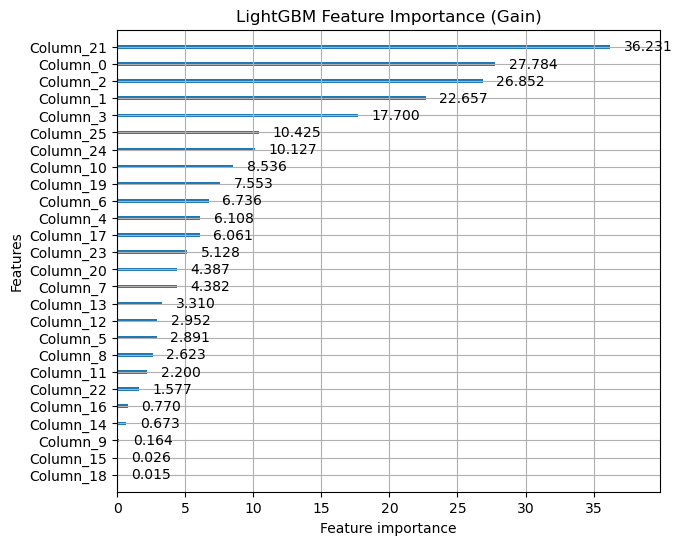

In [81]:
import lightgbm as lgb
lgb.plot_importance(modelo, importance_type="gain", figsize=(7,6), title="LightGBM Feature Importance (Gain)")
plt.show()

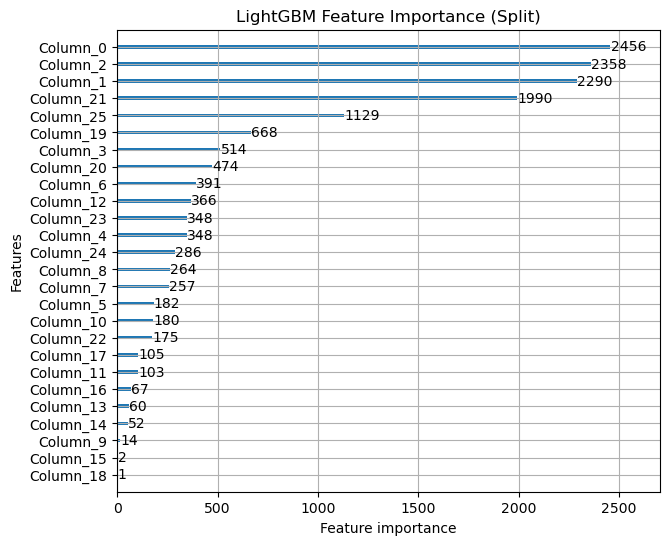

In [82]:
# Plot feature importance using Split
lgb.plot_importance(modelo, importance_type="split", figsize=(7,6), title="LightGBM Feature Importance (Split)")
plt.show()

In [83]:
# Save feature importance in text file
# Importance is measured in terms of gain according to LightGBM classifier
#np.savetxt('./ModeloFinalImp2.txt', modelo.booster_.feature_importance(importance_type='split'),fmt='%f')
#np.savetxt('./ModeloFinalImpG2.txt', modelo.booster_.feature_importance(importance_type='gain'),fmt='%f')

In [84]:
#Pongo el archivo q quiero testear
s3_url = f"viamericas-datalake-dev-us-east-1-283731589572-raw/FraudModel/Data4Model/TargetTodos"
tes = pd.read_parquet(f"s3://{s3_url}/Data2024/Data2024.parquet")

##lista de variables de input
X = tes[var_input]
Y = tes[['target']]

#testeo = pd.concat([testeo, tes], axis = 0, ignore_index=True)
#Y_target = pd.DataFrame(pd.concat([dfTrain[dias_target], dfVal[dias_target], tes[dias_target]], ignore_index=True)) 
testeo =  tes.copy()
Y_target = pd.DataFrame(tes[dias_target]) 

In [85]:
def limpiar_nombres_columnas(dataframe):
    """
    Limpia y estandariza los nombres de las columnas en un DataFrame.

    Parameters:
    - dataframe: DataFrame de pandas.

    Returns:
    - DataFrame con nombres de columnas limpios.
    """
    dataframe = dataframe.rename(columns=lambda x: re.sub('[^A-Za-z0-9_]+', '', x))
    return dataframe

testeo = limpiar_nombres_columnas(testeo)

In [86]:
testeo['target'].value_counts(dropna=False)

target
False    6837338
True          62
Name: count, dtype: int64

In [87]:
# Prediciendo la variable objetivo para el conjunto de datos de prueba 'X_TESTEO' utilizando el clasificador LightGBM
testeo_data_pred_rf = modelo.predict(testeo[var_input])

# Prediciendo las probabilidades de clase para cada observación en 'X_TESTEO' utilizando el clasificador LightGBM
probab_rf = modelo.predict_proba(testeo[var_input])

# Eliminando la primera columna (se asume que son las probabilidades de la clase negativa) de las probabilidades predichas
# Se asume que la segunda columna contiene las probabilidades para la clase positiva
score_rf = np.delete(probab_rf, np.s_[0], axis=1)


In [88]:
# Creando una copia del DataFrame 'Y_TESTEO' para preservar los datos originales
Y_c = Y_target.copy()

# Agregando una nueva columna 'preds_rf' al DataFrame copiado con las predicciones del clasificador LightGBM
Y_c['preds_rf'] = testeo_data_pred_rf

# Agregando una nueva columna 'score_rf' al DataFrame copiado con las probabilidades de la clase positiva
Y_c['score_rf'] = score_rf

In [89]:
pd.DataFrame(confusion_matrix(Y_c['target'], Y_c['preds_rf']))

,0,1
0,6837338,0
1,61,1


In [90]:
corte

6.629883834307124e-07

In [91]:
Y_c['pred_corte'] = Y_c['score_rf']>corte2
pd.DataFrame(confusion_matrix(Y_c['target'], Y_c['pred_corte']))

,0,1
0,6827206,10132
1,40,22


In [92]:
#import seaborn as sns
#sns.histplot(data = Y_c[Y_c['target'] == True], x='score_rf')

In [93]:
# Dividir las predicciones en deciles y calcular la captura del 30% en el conjunto de entrenamiento
percentiles = pd.qcut(Y_c['score_rf'], q=1000, duplicates='drop')
percentile_label = {p: l for l, p in enumerate(sorted(percentiles.unique(), reverse=True), start=1)}
percentiles = percentiles.map(percentile_label)
Y_c['FRAUD_DECILE'] = np.nan
Y_c['FRAUD_DECILE'] = percentiles
Y_c['FRAUD_DECILE'] = Y_c['FRAUD_DECILE'].astype('Int32')
print('FRAUD CAPTURA .04%:')
print(sum(Y_c[Y_c['FRAUD_DECILE'] < 4]['target']) / sum(Y_c['target']))
#Y_TESTEO_c.to_csv(r'./SCORES/primera_prueba.csv')

FRAUD CAPTURA .04%:
0.41935483870967744


In [94]:
DECILES = pd.crosstab(Y_c['FRAUD_DECILE'], Y_c['target'])
DECILES

target,False,True
FRAUD_DECILE,,
1,6819,18
2,6832,6
3,6836,2
4,6835,2
5,6833,4
...,...,...
996,6837,0
997,6837,0
998,6838,0


In [95]:
Y_c[['score_rf','FRAUD_DECILE']].groupby(['FRAUD_DECILE']).agg({'score_rf': [ 'min', 'max']}) 

score_rf                       
                                min                    max
FRAUD_DECILE                                              
1            0.00000011118144638582 0.53654959056976392340
2            0.00000004377948894800 0.00000011116722347629
3            0.00000002541455006086 0.00000004377871035178
4            0.00000001732835850295 0.00000002541366506603
5            0.00000001276068358040 0.00000001732375893725
...                             ...                    ...
996          0.00000000000006909231 0.00000000000008001506
997          0.00000000000005747586 0.00000000000006909229
998          0.00000000000004470107 0.00000000000005747175
999          0.00000000000002967331 0.00000000000004470001
1000         0.00000000000000145587 0.00000000000002966653

[1000 rows x 2 columns]

In [96]:
tes_corte = testeo[Y_c['pred_corte']==True]
Y_c_corte = Y_c[Y_c['pred_corte']==True]
pd.crosstab(tes_corte['date_receiver'].dt.month, Y_c_corte['target'])
#pd.crosstab(testeo['date_receiver'].dt.month, Y_c['target'])

target,False,True
date_receiver,,
1,2913,15
2,3670,3
3,3549,4


In [97]:
tes_corte.to_csv ('./Corte.csv')

In [98]:
deciles_semana = Y_c[['day_name_receiver_0', 'day_name_receiver_1',
                   'day_name_receiver_2', 'day_name_receiver_3',
                   'day_name_receiver_4', 'day_name_receiver_5',
                   'day_name_receiver_6',
                 'FRAUD_DECILE']].groupby(['FRAUD_DECILE']).sum()

deciles_semana.head(10)

,day_name_receiver_0,day_name_receiver_1,day_name_receiver_2,day_name_receiver_3,day_name_receiver_4,day_name_receiver_5,day_name_receiver_6
FRAUD_DECILE,,,,,,,
1,933,845,735,766,1184,1329,1045
2,939,793,689,780,1196,1387,1054
3,901,842,711,751,1204,1372,1057
4,933,784,707,739,1204,1362,1108
5,944,816,723,736,1162,1392,1064
6,888,802,721,704,1219,1374,1130
7,921,844,663,737,1186,1394,1092
8,895,759,720,777,1131,1395,1161
9,960,794,708,731,1128,1362,1154


In [99]:
#DECILES.to_csv ('./deciles.csv')

# Buckets para codificar Score

In [100]:
 Y_c['FRAUD_DECILE'].value_counts()

FRAUD_DECILE
281    6839
369    6839
344    6839
349    6839
56     6839
       ... 
425    6836
739    6836
55     6836
959    6836
839    6836
Name: count, Length: 1000, dtype: Int64

In [101]:
#Guardo los puntos de corte para recodificar el score
pd.options.display.float_format = "{:,.20f}".format
Buckets = Y_c[['score_rf','FRAUD_DECILE']].groupby(['FRAUD_DECILE']).agg({'score_rf': [ 'min', 'max']}).stack(0, future_stack=True)
Buckets = Buckets.reset_index()
Buckets['final_score'] = 1-(Buckets['FRAUD_DECILE']/1000)
Buckets[['FRAUD_DECILE','min','max','final_score']].to_csv ('./Buckets.csv')

Y_c['score_rf2'] = 0
Y_c['score_rf2'] = Y_c['score_rf2'].astype(str) 
for i in range(Y_c.shape[0]):
    a = Buckets.loc[(Y_c.loc[i,'score_rf'] <= Buckets['max']) & (Y_c.loc[i,'score_rf'] >= Buckets['min']), 'final_score'] 
    Y_c.loc[i,'score_rf2'] = a.item()

In [102]:
#Y_c.loc[1,['score_rf2','FRAUD_DECILE']] 

In [103]:
Y_c.iloc[1]

day_name_receiver_0                    False
day_name_receiver_1                    False
day_name_receiver_2                    False
day_name_receiver_3                    False
day_name_receiver_4                     True
day_name_receiver_5                    False
day_name_receiver_6                    False
target                                 False
preds_rf                               False
score_rf              0.00000000001892324449
pred_corte                             False
FRAUD_DECILE                             380
Name: 1, dtype: object

In [104]:
Buckets[Buckets['FRAUD_DECILE']==644]

,FRAUD_DECILE,level_1,min,max,final_score
643,644,score_rf,0.00000000000486828027,0.00000000000489336366,0.35599999999999998312


## Curva ROC y FP

In [105]:
pip install scikit-plot

Note: you may need to restart the kernel to use updated packages.


In [106]:
%pip install scipy==1.11.4

Note: you may need to restart the kernel to use updated packages.


In [107]:
from sklearn.metrics import roc_auc_score
from scikitplot.metrics import plot_roc
from scikitplot.metrics import plot_lift_curve
from scikitplot.helpers import binary_ks_curve
from scikitplot.metrics import plot_ks_statistic
from scikitplot.helpers import cumulative_gain_curve

In [108]:
# Calcular la curva de ganancia acumulativa y el LIFT del modelo en el conjunto de entrenamiento
classes = np.unique(Y_c[['target']])
percentages, gains = cumulative_gain_curve(Y_c[['target']], Y_c['score_rf'], classes[1])
percentages = percentages[1:]
gains = gains[1:]
gains = gains / percentages
indice = round(len(gains) * 0.1)
print('LIFT FRAUD TESTEO:')
print(gains[indice])

# Calcular el área bajo la curva ROC del modelo en el conjunto de entrenamiento
print('ROC FRAUD TESTEO:')
print(roc_auc_score(Y_c[['target']], Y_c['preds_rf']))

# Calcular la estadística KS del modelo en el conjunto de entrenamiento
thresholds, pct1, pct2, ks_statistic, max_distance_at, classes = binary_ks_curve(Y_c[['target']], Y_c['score_rf'])
print('KS FRAUD TESTEO:')
print(ks_statistic)

# Calcular la precisión y el recall del modelo en el conjunto de entrenamiento
precision = precision_score(Y_c[['target']], Y_c['preds_rf'])
recall = recall_score(Y_c[['target']], Y_c['preds_rf'])
print('Precision FRAUD TESTEO:')
print(precision)
print('Recall FRAUD TESTEO:')
print(recall)

LIFT FRAUD TESTEO:
8.387084507711394
ROC FRAUD TESTEO:
0.5080645161290323


/home/ec2-user/anaconda3/envs/python3/lib/python3.10/site-packages/sklearn/preprocessing/_label.py:114: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


KS FRAUD TESTEO:
0.7706786594243209
Precision FRAUD TESTEO:
1.0
Recall FRAUD TESTEO:
0.016129032258064516


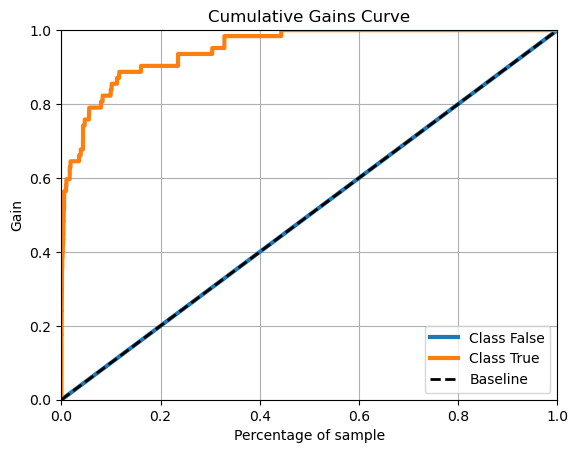

In [109]:
import scikitplot as skplt
skplt.metrics.plot_cumulative_gain(y_true=Y_c[['target']], y_probas =  probab_rf)
plt.show()

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


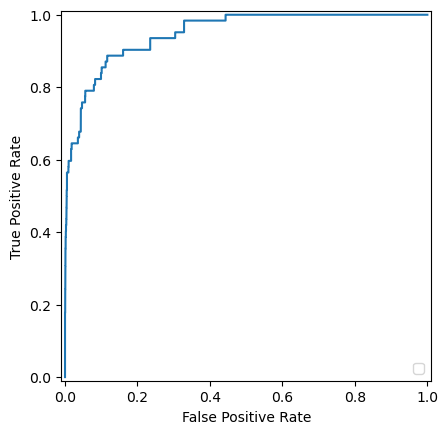

In [110]:
from sklearn.metrics import RocCurveDisplay, roc_curve

fpr, tpr, _ = roc_curve(Y_c[['target']], score_rf)
roc_display = RocCurveDisplay(fpr=fpr, tpr=tpr).plot()

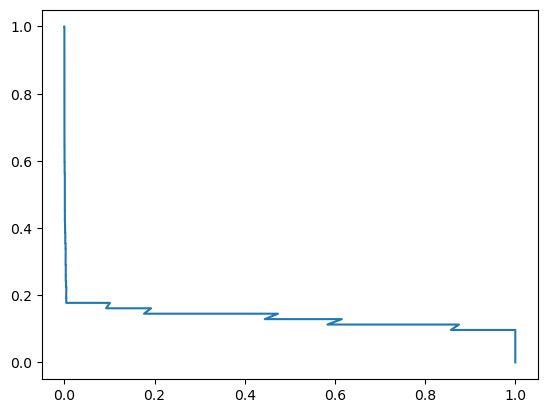

In [111]:
precision, recall, thresholds = skplt.metrics.precision_recall_curve(Y_c[['target']], score_rf)
plt.plot(precision, recall)

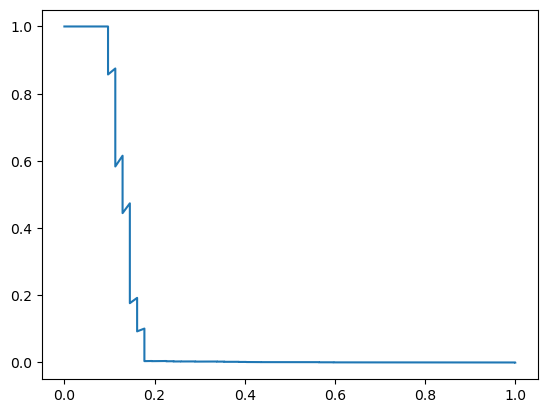

In [112]:
plt.plot(recall, precision)

## One given week

In [113]:
tes[tes['target']==True].head()

,id_branch,id_receiver,date_receiver,id_location,id_payer,id_sender_global,net_amount_receiver,receiver_transaction_count,id_country_receiver_claim,id_state_receiver_claim,id_state,branch_working_days,sender_sending_days,sender_days_to_last_transaction,id_country,fraud_classification,sender_minutes_since_last_transaction,branch_minutes_since_last_transaction,sender_days_since_last_transaction,branch_trans_3m,sender_state,branch_has_fraud,receiver_has_fraud,branch_trans_40min,branch_trans_10min,cash_pick_up_40min,location_nro_fraud,sender_trans_3m,range_hist,sender_nro_fraud,mes,hour_receiver,01_isMexico,01_sender_branch_state,01_var_range_hist,01_receiver_fraud,01_branch_fraud,01_location_fraud,01_sender_fraud,01_isCashPick,01_isBankDep,sender_days_to_last_transaction_365,sender_days_to_last_transaction_more365,sender_days_to_last_transaction_7m,sender_days_to_last_transaction_more7m,sender_minutes_since_last_transaction_2days,sender_minutes_since_last_transaction_1day,01_receiver_transaction_count,01_sender_sending_days,01_branch_working_days,01_net_amount_receiver,01_sender_minutes_since_last_transaction_2days,01_sender_minutes_since_last_transaction_1day,01_sender_days_to_last_transaction_365,01_sender_days_to_last_transaction_7m,01_hour_receiver,day_name_receiver_0,day_name_receiver_1,day_name_receiver_2,day_name_receiver_3,day_name_receiver_4,day_name_receiver_5,day_name_receiver_6,id_payout_A,id_payout_C,id_payout_D,id_payout_G,id_payout_M,id_payout_N,id_payout_O,id_payout_P,id_payout_S,id_payout_T,id_payout_X,targetR,targetP,target
231933,A25718,47,2024-01-24 18:24:18.070,NY1546,NN,11306118,"1,500.00000000000000000000",1.00000000000000000000,MEX,MEX25,NY,65,NaN,NaN,USA,Real,NaN,8.00000000000000000000,0,40,CA,2,0,3,2,0,2,1,"1,500.00000000000000000000",0,1,18,True,False,1.00000000000000000000,False,True,True,False,False,True,NaN,0,NaN,0,NaN,NaN,0.00000000000000000000,NaN,0.01331311088641725683,0.54840195669818159185,NaN,NaN,NaN,NaN,0.75000000000000000000,False,False,True,False,False,False,False,False,True,False,False,False,False,False,False,False,False,False,False,True,True
269827,A25718,46,2024-01-24 18:16:31.533,NY1546,NN,10303412,"1,500.00000000000000000000",1.00000000000000000000,MEX,MEX33,NY,65,210.00000000000000000000,34.00000000000000000000,USA,Real,"49,208.00000000000000000000",9.00000000000000000000,0,39,CA,1,1,2,2,0,1,2,"1,700.00000000000000000000",1,1,18,True,False,0.88235294117647056211,True,True,True,True,False,True,34.00000000000000000000,0,34.00000000000000000000,0,0.00000000000000000000,0.00000000000000000000,0.00000000000000000000,0.29329608938547485630,0.01331311088641725683,0.54840195669818159185,0.00000000000000000000,0.00000000000000000000,0.09315068493150685525,0.16190476190476191243,0.75000000000000000000,False,False,True,False,False,False,False,False,True,False,False,False,False,False,False,False,False,False,False,True,True
308307,A22792,11766,2024-01-19 17:47:25.867,NV0185,NN,11283276,980.00000000000000000000,1.00000000000000000000,MEX,MEX27,NV,583,NaN,NaN,USA,Real,NaN,30.00000000000000000000,0,2475,NV,3,0,1,1,0,3,1,980.00000000000000000000,0,1,17,True,True,1.00000000000000000000,False,True,True,False,False,True,NaN,0,NaN,0,NaN,NaN,0.00000000000000000000,NaN,0.10060667340748230547,0.35828927837614527041,NaN,NaN,NaN,NaN,0.70833333333333337034,False,False,False,False,True,False,False,False,True,False,False,False,False,False,False,False,False,False,False,True,True
468554,A25581,183,2024-01-07 19:55:34.963,SC0729,NN,11235795,980.00000000000000000000,1.00000000000000000000,MEX,MEX44,SC,66,NaN,NaN,USA,Real,NaN,28.00000000000000000000,0,173,SC,3,0,2,1,0,3,1,980.00000000000000000000,0,1,19,True,True,1.00000000000000000000,False,True,True,False,False,True,NaN,0,NaN,0,NaN,NaN,0.00000000000000000000,NaN,0.01348163127738456410,0.35828927837614527041,NaN,NaN,NaN,NaN,0.79166666666666662966,False,False,False,False,False,False,True,False,True,False,False,False,False,False,False,False,False,False,False,True,True
4

In [114]:
week_testigo = tes['date_receiver'].between('2024-01-01','2024-01-30')
X_week_testigo = tes[week_testigo]
Y_c_week_testigo = Y_c[week_testigo]

week_testigo.sum(), X_week_testigo.shape, Y_c_week_testigo.shape

(1972832, (1972832, 77), (1972832, 12))

In [115]:
pd.crosstab(X_week_testigo['date_receiver'].dt.day, Y_c_week_testigo['target'])

target,False,True
date_receiver,,
1,14877,0
2,64369,0
3,53021,0
4,53556,0
5,82215,1
6,89445,0
7,75931,6
8,64412,0
9,49193,0


In [116]:
#Veo cuantos falsos positivos tengo con el punto de corte
X_week_testigo_corte = X_week_testigo[Y_c_week_testigo['pred_corte']==True]
Y_c_week_testigo_corte = Y_c_week_testigo[Y_c_week_testigo['pred_corte']==True]

pd.crosstab(X_week_testigo_corte['date_receiver'].dt.day, Y_c_week_testigo_corte['target'])

target,False,True
date_receiver,,
1,27,0
2,90,0
3,76,0
4,65,0
5,93,0
6,93,0
7,72,5
8,97,0
9,60,0


In [117]:
Tabla_Week = pd.DataFrame(pd.concat([X_week_testigo['date_receiver'].dt.day,X_week_testigo['fraud_classification'], 
                                     Y_c_week_testigo['FRAUD_DECILE'], Y_c_week_testigo['target']],axis=1))

In [118]:
Tabla_Week[Tabla_Week['target']==True]
pd.crosstab(Tabla_Week.date_receiver, Tabla_Week.FRAUD_DECILE)

FRAUD_DECILE,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,40,41,42,43,44,45,46,47,48,49,50,51,52,53,54,55,56,57,58,59,60,61,62,63,64,65,66,67,68,69,70,71,72,73,74,75,76,77,78,79,80,81,82,83,84,85,86,87,88,89,90,91,92,93,94,95,96,97,98,99,100,101,102,103,104,105,106,107,108,109,110,111,112,113,114,115,116,117,118,119,120,121,122,123,124,125,126,127,128,129,130,131,132,133,134,135,136,137,138,139,140,141,142,143,144,145,146,147,148,149,150,151,152,153,154,155,156,157,158,159,160,161,162,163,164,165,166,167,168,169,170,171,172,173,174,175,176,177,178,179,180,181,182,183,184,185,186,187,188,189,190,191,192,193,194,195,196,197,198,199,200,201,202,203,204,205,206,207,208,209,210,211,212,213,214,215,216,217,218,219,220,221,222,223,224,225,226,227,228,229,230,231,232,233,234,235,236,237,238,239,240,241,242,243,244,245,246,247,248,249,250,...,751,752,753,754,755,756,757,758,759,760,761,762,763,764,765,766,767,768,769,770,771,772,773,774,775,776,777,778,779,780,781,782,783,784,785,786,787,788,789,790,791,792,793,794,795,796,797,798,799,800,801,802,803,804,805,806,807,808,809,810,811,812,813,814,815,816,817,818,819,820,821,822,823,824,825,826,827,828,829,830,831,832,833,834,835,836,837,838,839,840,841,842,843,844,845,846,847,848,849,850,851,852,853,854,855,856,857,858,859,860,861,862,863,864,865,866,867,868,869,870,871,872,873,874,875,876,877,878,879,880,881,882,883,884,885,886,887,888,889,890,891,892,893,894,895,896,897,898,899,900,901,902,903,904,905,906,907,908,909,910,911,912,913,914,915,916,917,918,919,920,921,922,923,924,925,926,927,928,929,930,931,932,933,934,935,936,937,938,939,940,941,942,943,944,945,946,947,948,949,950,951,952,953,954,955,956,957,958,959,960,961,962,963,964,965,966,967,968,969,970,971,972,973,974,975,976,977,978,979,980,981,982,983,984,985,986,987,988,989,990,991,992,993,994,995,996,997,998,999,1000
date_receiver,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
1,19,16,13,13,17,9,17,24,13,21,19,7,14,23,9,14,14,11,20,12,14,12,8,16,17,25,17,14,15,18,19,14,19,11,4,14,20,8,14,12,12,10,14,19,14,18,18,23,12,21,11,16,11,19,7,9,16,11,10,9,15,15,17,12,13,12,15,12,15,13,13,12,8,10,11,17,15,18,14,17,13,10,15,14,18,10,18,22,8,13,14,10,19,21,16,14,11,18,20,6,9,17,15,17,15,14,16,11,19,11,17,25,18,19,18,17,17,10,15,12,16,14,12,12,21,14,12,14,11,17,12,8,20,14,9,12,11,10,15,12,18,10,11,9,11,13,19,18,10,14,17,11,12,14,21,10,9,12,20,19,12,19,18,12,17,12,14,16,16,14,16,19,15,14,13,16,8,14,15,10,14,10,22,21,8,16,8,9,15,16,14,14,16,15,16,21,15,10,14,14,16,9,15,13,22,11,13,9,11,10,11,8,17,11,12,12,19,15,13,14,22,15,21,20,17,11,14,9,11,20,11,19,16,16,3,21,14,22,12,27,13,14,21,23,21,12,15,18,17,15,...,7,13,13,15,13,8,17,20,13,16,12,15,14,20,19,16,10,9,18,15,12,15,15,15,25,10,23,14,15,8,13,9,7,12,11,19,9,13,18,16,13,17,22,21,16,6,13,9,13,19,20,14,21,21,10,18,11,9,14,15,14,18,16,13,13,14,20,17,8,17,23,11,9,15,16,10,17,17,12,12,12,15,16,11,24,15,18,18,17,13,10,16,12,11,14,15,10,18,17,22,20,17,13,16,13,13,17,10,18,23,20,15,19,10,17,16,7,14,15,17,14,18,21,17,9,13,15,10,19,12,14,13,10,14,15,11,14,12,12,15,24,17,12,6,6,18,20,11,20,12,18,18,18,9,13,9,20,8,18,15,12,14,12,22,12,19,14,14,15,14,11,17,12,21,19,11,13,27,14,9,22,20,17,18,9,21,18,13,19,10,12,23,10,15,18,13,21,13,20,16,15,16,13,12,16,13,19,25,17,20,17,13,14,15,22,24,14,14,14,13,17,19,19,11,20,30,23,23,14,16,23,28,20,17,20,14,19,32,20,14,22,28,21,22,24,24,26,23,26,11
2,65,52,46,53,45,52,73,53,61,52,61,62,53,62,67,62,60,45,53,44,64,61,57,59,63,65,53,69,68,56,60,54,55,57,77,76,55,75,

In [119]:

pd.crosstab(Tabla_Week.date_receiver[Tabla_Week['target']==True], Tabla_Week.FRAUD_DECILE[Tabla_Week['target']==True])

FRAUD_DECILE,1,2,4,5,36,56,117
date_receiver,,,,,,,
5,0,0,0,0,0,0,1
7,5,0,0,0,1,0,0
14,2,0,0,0,0,1,0
19,1,3,1,0,0,0,0
21,3,0,0,1,0,0,0
24,3,0,0,0,0,0,0


In [120]:
Tabla_Week.loc[Tabla_Week['target']==True,['date_receiver','fraud_classification','FRAUD_DECILE']]

,date_receiver,fraud_classification,FRAUD_DECILE
231933,24,Real,1
269827,24,Real,1
308307,19,Real,4
468554,7,Real,1
475176,5,Real,117
507041,24,Real,1
522317,21,Real,1
526070,14,Real,56
675600,21,Real,1
712534,21,Real,5


# Analisis extra por cantidad FP

In [121]:
testeo.loc[(testeo['id_receiver'] ==30890) & (testeo['id_branch'] =='A14536')] 
#testeo['id_branch'] =='A14536'

,id_branch,id_receiver,date_receiver,id_location,id_payer,id_sender_global,net_amount_receiver,receiver_transaction_count,id_country_receiver_claim,id_state_receiver_claim,id_state,branch_working_days,sender_sending_days,sender_days_to_last_transaction,id_country,fraud_classification,sender_minutes_since_last_transaction,branch_minutes_since_last_transaction,sender_days_since_last_transaction,branch_trans_3m,sender_state,branch_has_fraud,receiver_has_fraud,branch_trans_40min,branch_trans_10min,cash_pick_up_40min,location_nro_fraud,sender_trans_3m,range_hist,sender_nro_fraud,mes,hour_receiver,01_isMexico,01_sender_branch_state,01_var_range_hist,01_receiver_fraud,01_branch_fraud,01_location_fraud,01_sender_fraud,01_isCashPick,01_isBankDep,sender_days_to_last_transaction_365,sender_days_to_last_transaction_more365,sender_days_to_last_transaction_7m,sender_days_to_last_transaction_more7m,sender_minutes_since_last_transaction_2days,sender_minutes_since_last_transaction_1day,01_receiver_transaction_count,01_sender_sending_days,01_branch_working_days,01_net_amount_receiver,01_sender_minutes_since_last_transaction_2days,01_sender_minutes_since_last_transaction_1day,01_sender_days_to_last_transaction_365,01_sender_days_to_last_transaction_7m,01_hour_receiver,day_name_receiver_0,day_name_receiver_1,day_name_receiver_2,day_name_receiver_3,day_name_receiver_4,day_name_receiver_5,day_name_receiver_6,id_payout_A,id_payout_C,id_payout_D,id_payout_G,id_payout_M,id_payout_N,id_payout_O,id_payout_P,id_payout_S,id_payout_T,id_payout_X,targetR,targetP,target
4507161,A14536,30890,2024-03-20 12:42:15.783,MA0108,NN,5717054,"1,050.50000000000000000000",1.00000000000000000000,BRA,BRA2,MA,2751,888.00000000000000000000,35.00000000000000000000,USA,None,"50,478.00000000000000000000",24.00000000000000000000,0,1116,MA,0,0,2,1,0,0,4,"2,492.06999999999970896170",0,3,12,False,True,0.42153711573109908795,False,False,False,False,False,True,35.00000000000000000000,0,35.00000000000000000000,0,0.00000000000000000000,0.00000000000000000000,0.00000000000000000000,1.00000000000000000000,0.47744423947677344655,0.37924187725631769430,0.00000000000000000000,0.00000000000000000000,0.09589041095890410427,0.16666666666666665741,0.50000000000000000000,False,False,True,False,False,False,False,False,False,False,False,False,False,False,False,False,False,True,False,False,False


In [122]:
sns.histplot(data = tes_corte['date_receiver'].dt.floor('d'))

NameError: name 'sns' is not defined

In [ ]:
sns.histplot(data = testeo['date_receiver'].dt.floor('d'))

In [ ]:

Alertas_2024 = pd.crosstab(tes_corte['date_receiver'].dt.floor('d'), Y_c_corte['target'])
Alertas_2024.to_csv ('./alertas2024.csv')

In [ ]:
testeo[testeo['mes']==1].describe()

In [ ]:
testeo[testeo['mes']==3].describe()

for var in var_input:
    sns.histplot(data = tes_corte, x=var, hue = 'mes')
    plt.show()

In [ ]:
week_fraude = tes['date_receiver'].between('2024-02-02','2024-02-11')
X_fraude = tes[week_fraude]
Y_c_fraude = Y_c[week_fraude]
Y_c_fraude

In [ ]:
week_fraude = tes['date_receiver'].between('2024-03-21','2024-03-22')
X_fraude = tes[week_fraude]
Y_c_fraude = Y_c[week_fraude]
X_fraude[Y_c_fraude['pred_corte']==True].sort_values(by=['id_branch'])

In [ ]:
#Y_c[tes['id_barnch'].str.contains('A24793')].sort_values(by=['id_receiver'])
testeo.loc[(testeo['id_receiver'] ==5619) & (testeo['id_branch'] =='A24793')] 

In [ ]:

pd.crosstab(testeo.loc[Y_c['target']==True,'date_receiver'], Y_c.loc[Y_c['target']==True,'pred_corte'])
